<a href="https://colab.research.google.com/github/utsavnandi/vae/blob/main/Beta_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install einops -q

In [ ]:
from typing import Callable
import time
import random
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
# from einops import rearrange, reduce, repeat
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, FashionMNIST, MNIST

from tqdm import tqdm

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [ ]:
class Encoder(nn.Module):
    def __init__(
        self, in_channels: int = 1, hidden_dim: int = 8, z_dim: int = 2, linear_size: int = 144
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 5, stride=2, bias=False) #  ((kernel_size)*stride+1)*filters) => ((5*5)*2 + 0) * 8
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ReLU(True)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 3, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_dim * 2)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(hidden_dim * 2)

        self.mu = nn.Linear(linear_size, z_dim)
        self.log_var = nn.Linear(linear_size, z_dim)

    def forward(self, x: torch.Tensor):
        bs, latent_dim, h, w = x.shape
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = x.view(bs, -1)
        x = F.relu(x)
        return self.mu(x), self.log_var(x)

class Decoder(nn.Module):
    def __init__(
        self, in_channels: int = 1, hidden_dim: int = 8, z_dim: int = 2
    ):
        super().__init__()
        self.z_dim = z_dim
        self.convTrans1 = nn.ConvTranspose2d(z_dim, hidden_dim, 5, stride=1, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ReLU(True)
        self.convTrans2 = nn.ConvTranspose2d(hidden_dim, hidden_dim * 2, 3, stride=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(hidden_dim * 2)
        self.convTrans3 = nn.ConvTranspose2d(hidden_dim * 2, in_channels, 5, stride=1, padding=0, bias=True)
        self.bn3 = nn.BatchNorm2d(in_channels)
    
    def forward(self, x: torch.Tensor):
        bs, _ = x.shape
        x = x.view(bs, self.z_dim, 1, 1)
        x = self.act(self.bn1(self.convTrans1(x)))
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.act(self.bn2(self.convTrans2(x)))
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = nn.Sigmoid()(self.bn3(self.convTrans3(x)))
        return x

class VAE(nn.Module):
    def __init__(
        self, in_channels: int = 1, hidden_dim: int = 8, z_dim: int = 2, 
        linear_size: int = 144
    ):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dim, z_dim, linear_size)
        self.decoder = Decoder(in_channels, hidden_dim, z_dim)
    
    def forward_encoder(self, x: torch.Tensor):
        mu, sigma = self.encoder(x)
        return mu, sigma

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # module.weight.data.normal_(mean=0.0, std=1.)
            torch.nn.init.xavier_uniform(module.weight)
            # if module.bias is not None:
            #     module.bias.data.zero_()
        if isinstance(module, nn.Conv2d):
            # module.weight.data.normal_(mean=0.0, std=1.)
            torch.nn.init.xavier_uniform(module.weight)
            # if module.bias is not None:
            #     module.bias.data.zero_()
        if isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform(module.weight)
            # module.weight.data.normal_(mean=0.0, std=1.)
            # if module.bias is not None:
            #     module.bias.data.zero_()

    def reparametize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        dist = torch.distributions.normal.Normal(0, 1)
        if torch.cuda.is_available():
            dist.loc = dist.loc.cuda()
            dist.scale = dist.scale.cuda()
        z = mu + std*dist.sample(mu.shape)
        return z

    def forward_decoder(self, x: torch.Tensor):
        x = self.decoder(x)
        return x

    def forward(self, x: torch.Tensor):
        mu, logvar = self.forward_encoder(x)
        z = self.reparametize(mu, logvar)
        x = self.forward_decoder(z)
        return x, mu, logvar


In [ ]:
def train_one_epoch(
    model, optimizer, scheduler, data_loader, config, epoch, device
):
    model.train()
    running_loss = 0
    start_time = time.time()
    mu_list, log_var_l, bce_l, kl_l = [], [], [], []
    for image, label in tqdm(data_loader, total=len(data_loader)):
        image = image.to(device)

        output, mu, logvar = model(image)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        try:
            bce_loss = F.binary_cross_entropy(
                output.view(-1, 784), image.view(-1, 784), reduction='sum'
            )
        except:
            print(output.view(-1, 784))
            continue

        if epoch < 10:
            beta = config['beta_0']
        elif epoch < 20:
            beta = config['beta_1']
        else:
            beta = config['beta_2']
        loss =  bce_loss + beta * kl_loss

        bce_l.append(bce_loss.mean().detach().cpu().numpy())
        kl_l.append(kl_loss.mean().detach().cpu().numpy())
        mu_list.append(mu.mean().detach().cpu().numpy())
        log_var_l.append(logvar.mean().detach().cpu().numpy())
        running_loss += float(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

    print(f'Elapsed time {(time.time() - start_time):.1f}s')
    print('avg bce loss: ', np.array(bce_l).mean())
    print('avg kl loss: ', np.array(kl_l).mean())

    return running_loss/len(data_loader), np.array(mu_list).mean(), np.array(log_var_l).mean()

def eval_one_sample(model, config, mu, log_var, device):
    model.eval()
    mean = 0.1307
    std = 0.3081
    _, axs = plt.subplots(6, 6, figsize=(12, 12))
    axs = axs.flatten()
    with torch.no_grad():
        for ax in axs:
            dist = torch.distributions.normal.Normal(0, 1)
            if torch.cuda.is_available():
                dist.loc = dist.loc.cuda()
                dist.scale = dist.scale.cuda()
            z = mu + log_var*dist.sample(torch.randn([1, config['z_dim']], device=device).shape)
            y = model.forward_decoder(z)
            y = y[0]
            # y = mean + (y * std)
            ax.imshow(y.view(28, 28).cpu().numpy(), cmap='binary')
            ax.axis('off')
    plt.show()


In [ ]:
def train(model, config):
    if config['ds'] == 'FashionMNIST':
        mean = 0.2859
        std = 0.3530
        train_ds = FashionMNIST(
            root='/content/', train=True, 
            transform=transforms.Compose(
                [transforms.ToTensor()]), # transforms.Normalize(mean, std)
            download=True
        )
    elif config['ds'] == 'MNIST':
        mean = 0.1307
        std = 0.3081
        train_ds = MNIST(
            root='/content/', train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor()] # transforms.Normalize(mean, std)
            )
        )
    else:
        print('ds not supported')
        return

    train_dl = DataLoader(
        train_ds, batch_size=config['batch_size'], shuffle=True, 
        pin_memory=True, num_workers=config['num_workers']
    )

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    
    print('-'*100)
    for i in range(0, config['max_epoch']):
        loss, mu, logvar = train_one_epoch(
            model, optimizer, None, train_dl, config, i, device
        )
        print(
            f'Epoch {i} [loss (avg) {loss:.4f} | mu (sum): {mu} | logvar (sum): {logvar}]'
        )
        eval_one_sample(model, config, mu, logvar, device)
        print('-'*50)


--------------------------------------------------


100%|██████████| 938/938 [00:36<00:00, 25.46it/s]


Elapsed time 36.9s
avg bce loss:  29097.207
avg kl loss:  247.17194
Epoch 0 [loss (avg) 29591.5497 | mu (sum): 0.219181090593338 | logvar (sum): -1.6097980737686157]


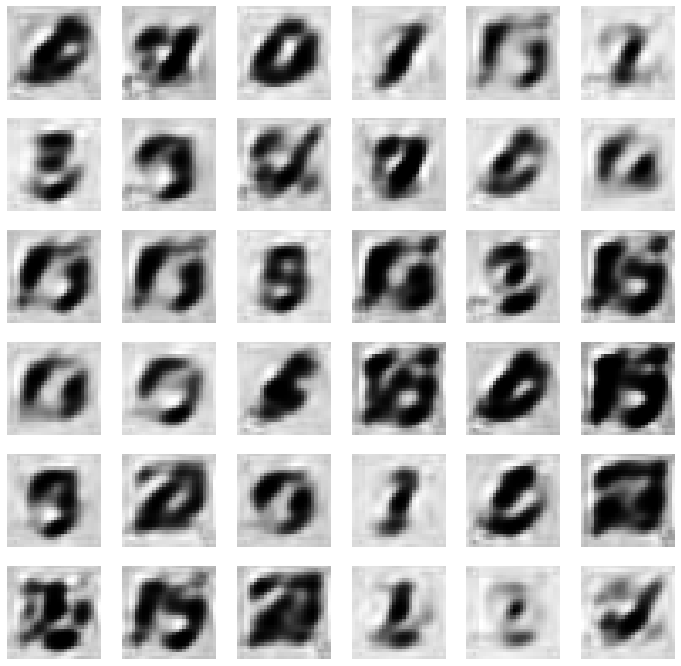

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.62it/s]


Elapsed time 38.1s
avg bce loss:  23196.566
avg kl loss:  354.27585
Epoch 1 [loss (avg) 23905.1170 | mu (sum): 0.11864632368087769 | logvar (sum): -2.729306936264038]


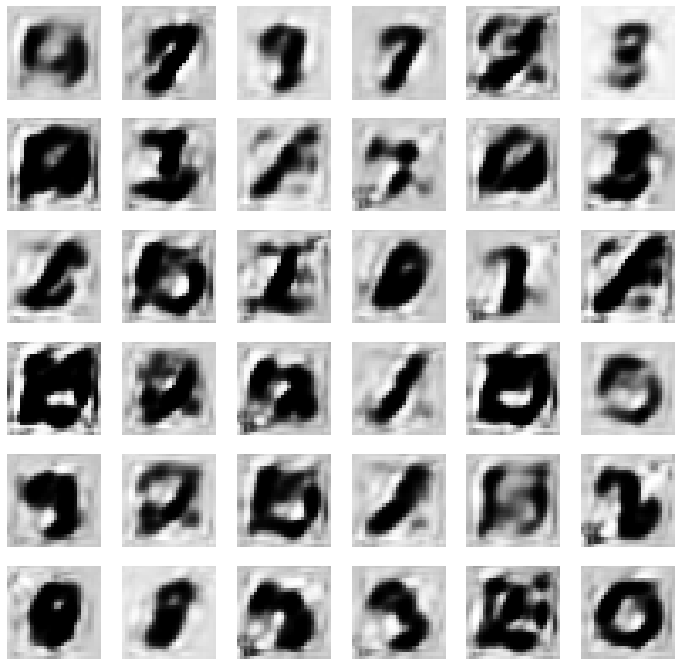

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.79it/s]


Elapsed time 39.5s
avg bce loss:  19737.938
avg kl loss:  399.51154
Epoch 2 [loss (avg) 20536.9626 | mu (sum): 0.1049407571554184 | logvar (sum): -3.1004161834716797]


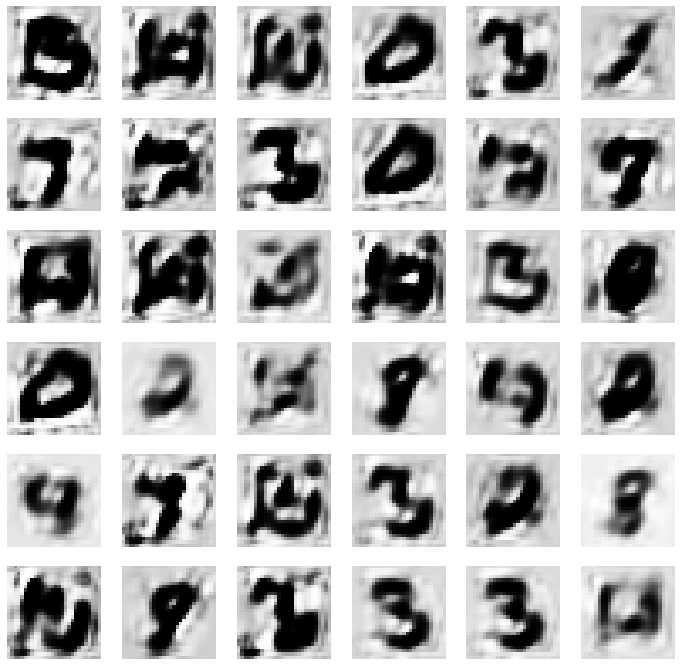

--------------------------------------------------


100%|██████████| 938/938 [00:37<00:00, 25.06it/s]


Elapsed time 37.4s
avg bce loss:  17268.465
avg kl loss:  418.5328
Epoch 3 [loss (avg) 18105.5307 | mu (sum): 0.09339901804924011 | logvar (sum): -3.2545080184936523]


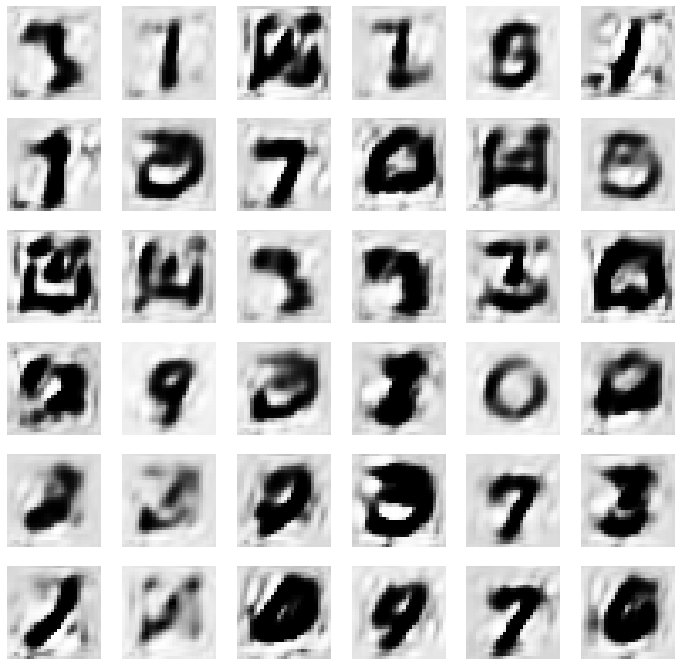

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Elapsed time 38.4s
avg bce loss:  15401.554
avg kl loss:  426.45718
Epoch 4 [loss (avg) 16254.4677 | mu (sum): 0.09337212890386581 | logvar (sum): -3.317000150680542]


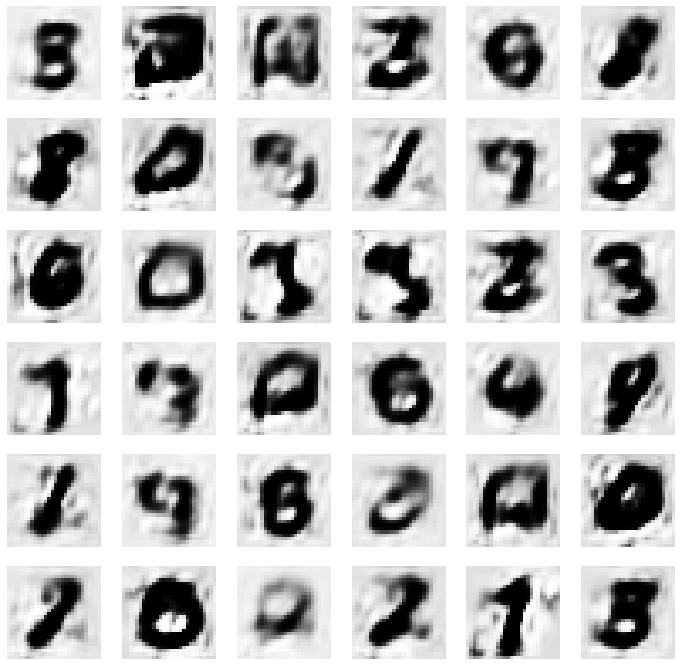

--------------------------------------------------


100%|██████████| 938/938 [00:36<00:00, 25.70it/s]


Elapsed time 36.5s
avg bce loss:  13946.549
avg kl loss:  427.3648
Epoch 5 [loss (avg) 14801.2786 | mu (sum): 0.08434545993804932 | logvar (sum): -3.3289635181427]


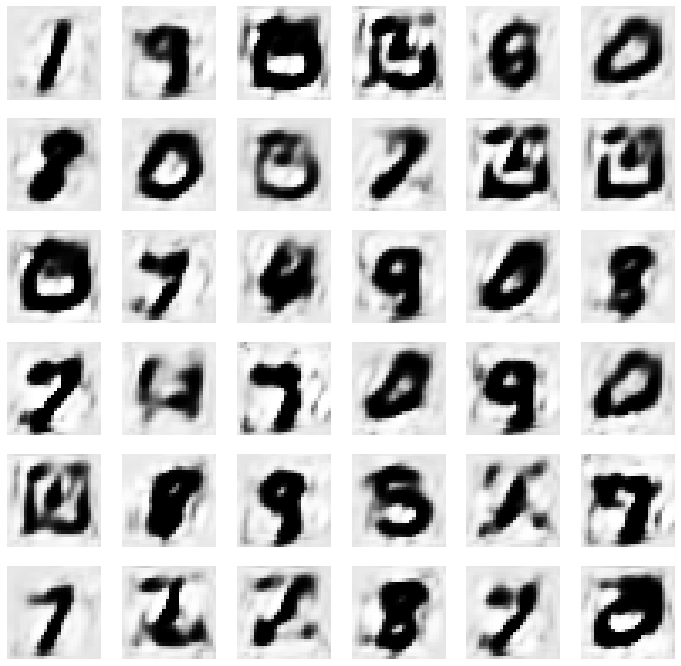

--------------------------------------------------


100%|██████████| 938/938 [00:36<00:00, 25.39it/s]


Elapsed time 37.0s
avg bce loss:  12809.145
avg kl loss:  429.08554
Epoch 6 [loss (avg) 13667.3163 | mu (sum): 0.0739593356847763 | logvar (sum): -3.3397254943847656]


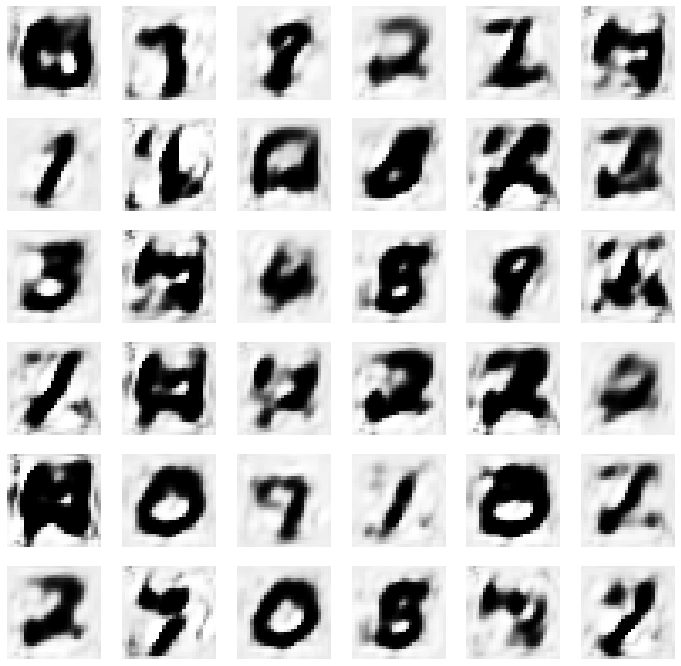

--------------------------------------------------


100%|██████████| 938/938 [00:37<00:00, 25.06it/s]


Elapsed time 37.4s
avg bce loss:  11927.498
avg kl loss:  432.617
Epoch 7 [loss (avg) 12792.7322 | mu (sum): 0.06949508190155029 | logvar (sum): -3.3683676719665527]


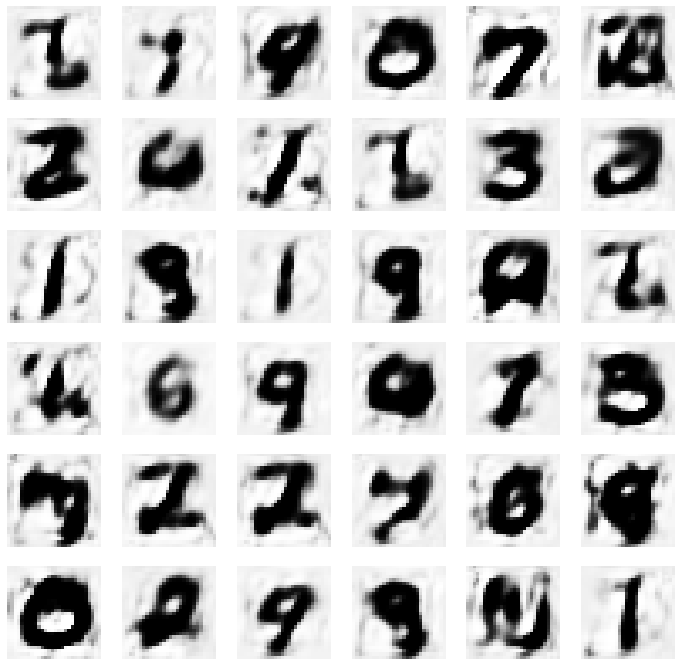

--------------------------------------------------


100%|██████████| 938/938 [00:37<00:00, 25.09it/s]


Elapsed time 37.4s
avg bce loss:  11246.136
avg kl loss:  437.65698
Epoch 8 [loss (avg) 12121.4499 | mu (sum): 0.06474437564611435 | logvar (sum): -3.4106669425964355]


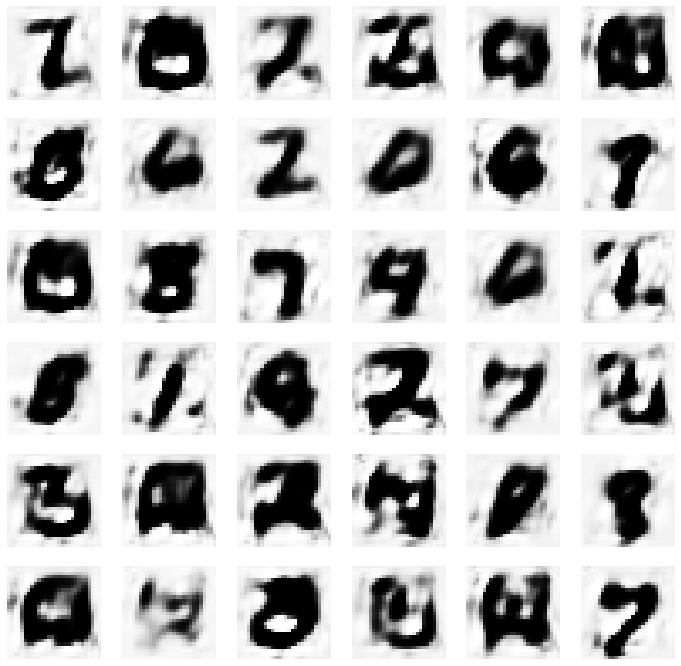

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.09it/s]


Elapsed time 39.0s
avg bce loss:  10717.887
avg kl loss:  442.59625
Epoch 9 [loss (avg) 11603.0796 | mu (sum): 0.06349426507949829 | logvar (sum): -3.4548144340515137]


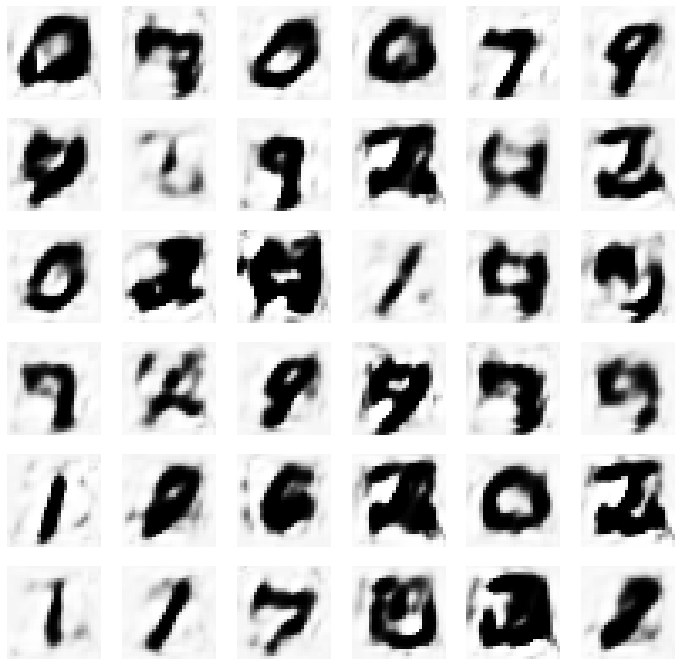

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.49it/s]


Elapsed time 38.3s
avg bce loss:  10613.362
avg kl loss:  346.74792
Epoch 10 [loss (avg) 12000.3550 | mu (sum): 0.05455305799841881 | logvar (sum): -2.714686632156372]


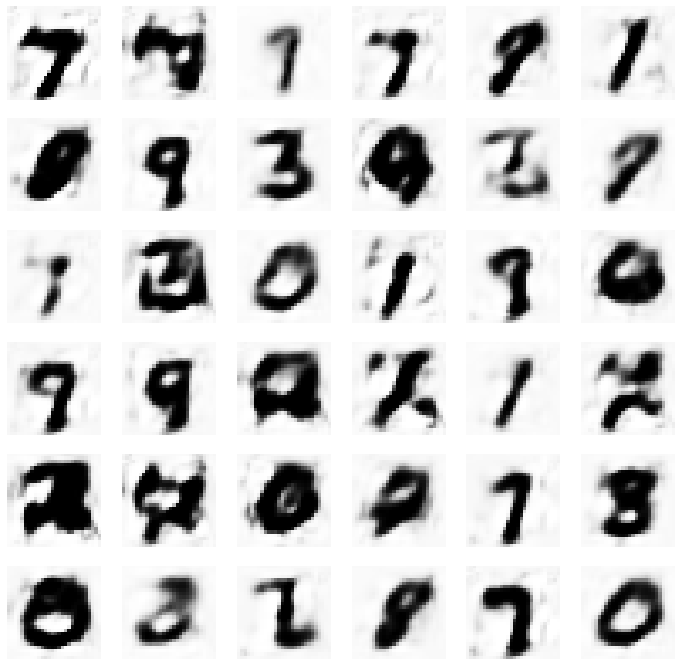

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.27it/s]


Elapsed time 38.7s
avg bce loss:  10344.704
avg kl loss:  341.16144
Epoch 11 [loss (avg) 11709.3498 | mu (sum): 0.051048051565885544 | logvar (sum): -2.667466878890991]


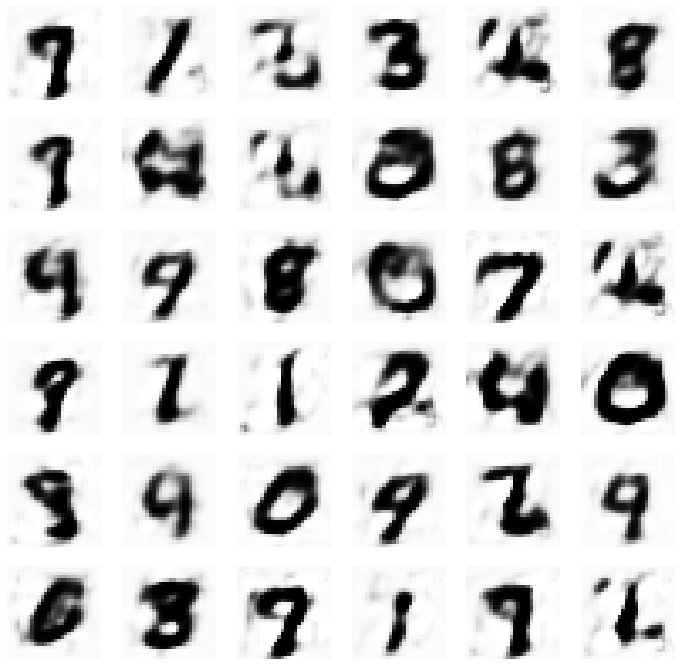

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


Elapsed time 38.2s
avg bce loss:  10119.023
avg kl loss:  343.2866
Epoch 12 [loss (avg) 11492.1702 | mu (sum): 0.05169234052300453 | logvar (sum): -2.685070037841797]


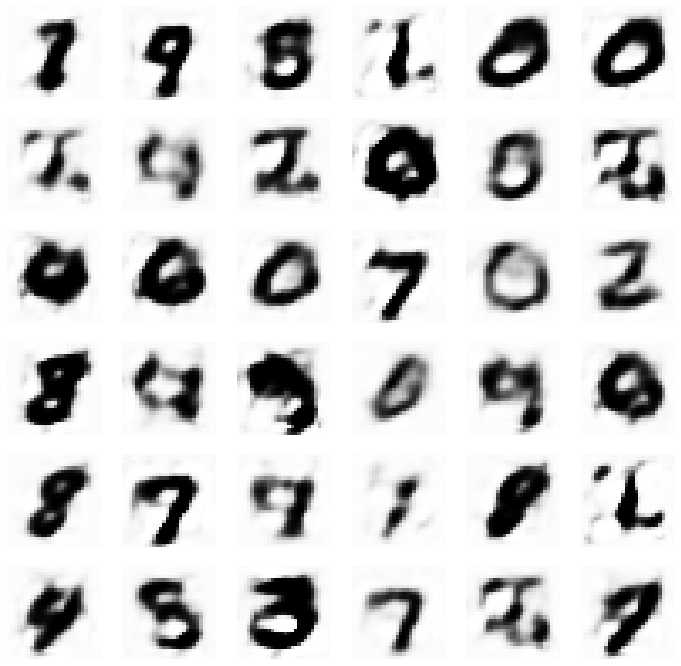

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 23.41it/s]


Elapsed time 40.1s
avg bce loss:  9947.968
avg kl loss:  344.19266
Epoch 13 [loss (avg) 11324.7387 | mu (sum): 0.05611604452133179 | logvar (sum): -2.688322067260742]


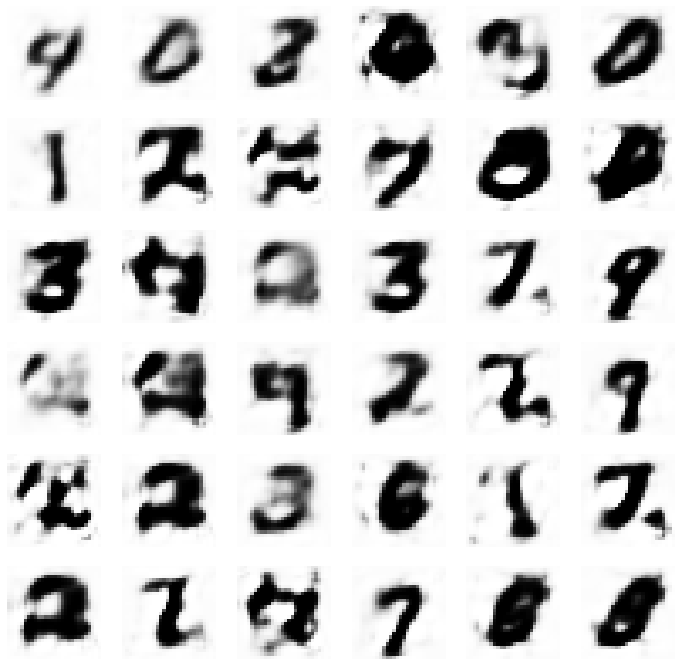

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Elapsed time 38.4s
avg bce loss:  9816.816
avg kl loss:  345.3343
Epoch 14 [loss (avg) 11198.1546 | mu (sum): 0.0577424019575119 | logvar (sum): -2.7011404037475586]


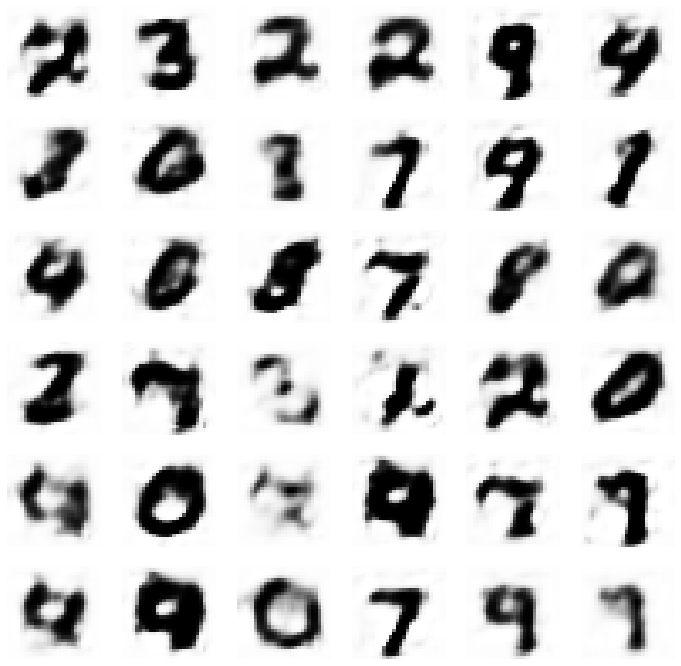

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.77it/s]


Elapsed time 39.5s
avg bce loss:  9719.409
avg kl loss:  346.71832
Epoch 15 [loss (avg) 11106.2832 | mu (sum): 0.06098111346364021 | logvar (sum): -2.7099125385284424]


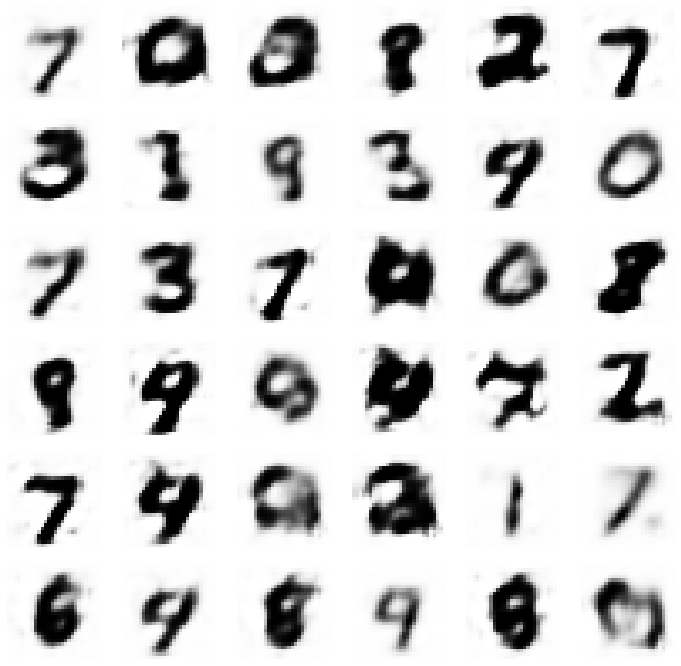

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 23.34it/s]


Elapsed time 40.2s
avg bce loss:  9634.886
avg kl loss:  347.41318
Epoch 16 [loss (avg) 11024.5382 | mu (sum): 0.06088746339082718 | logvar (sum): -2.7142436504364014]


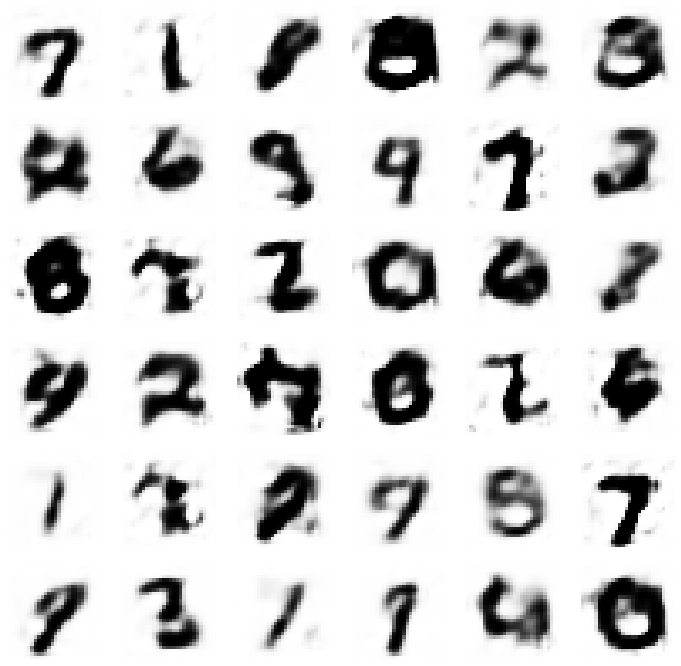

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 24.03it/s]


Elapsed time 39.0s
avg bce loss:  9577.714
avg kl loss:  348.87033
Epoch 17 [loss (avg) 10973.1958 | mu (sum): 0.060666609555482864 | logvar (sum): -2.7250356674194336]


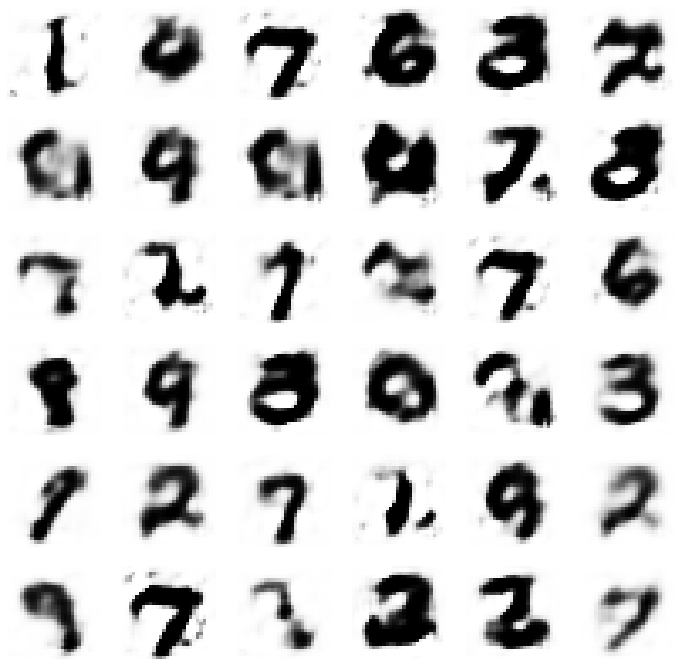

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.73it/s]


Elapsed time 39.5s
avg bce loss:  9534.949
avg kl loss:  349.01352
Epoch 18 [loss (avg) 10931.0034 | mu (sum): 0.05534275621175766 | logvar (sum): -2.7276077270507812]


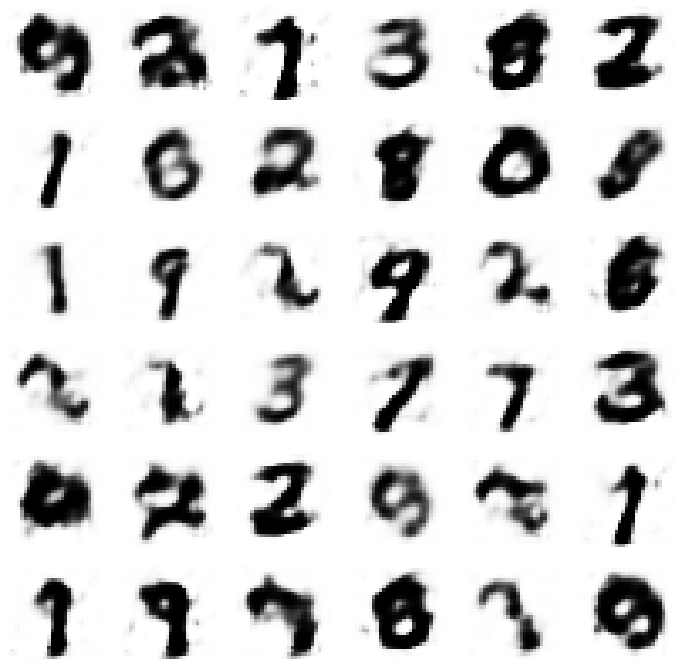

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.21it/s]


Elapsed time 38.7s
avg bce loss:  9498.672
avg kl loss:  350.35562
Epoch 19 [loss (avg) 10900.0940 | mu (sum): 0.05454955995082855 | logvar (sum): -2.7372782230377197]


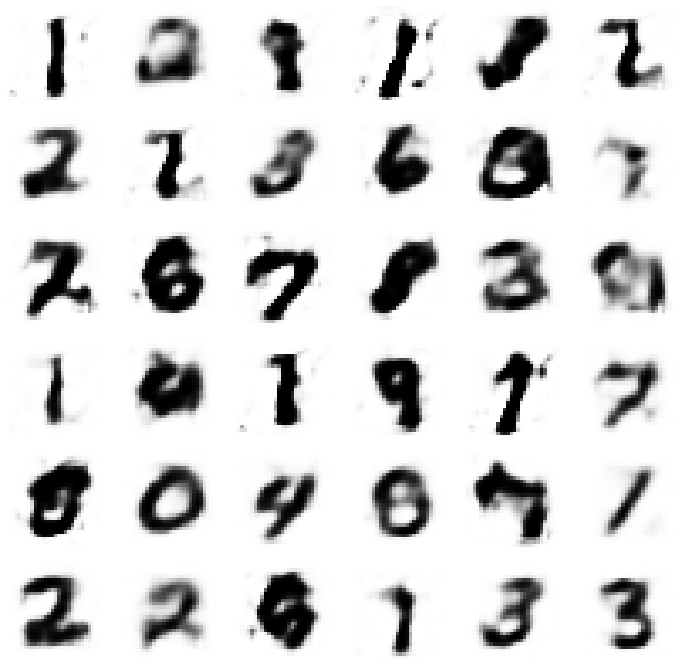

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.93it/s]


Elapsed time 39.2s
avg bce loss:  9476.257
avg kl loss:  349.99954
Epoch 20 [loss (avg) 10876.2548 | mu (sum): 0.05063853785395622 | logvar (sum): -2.732231378555298]


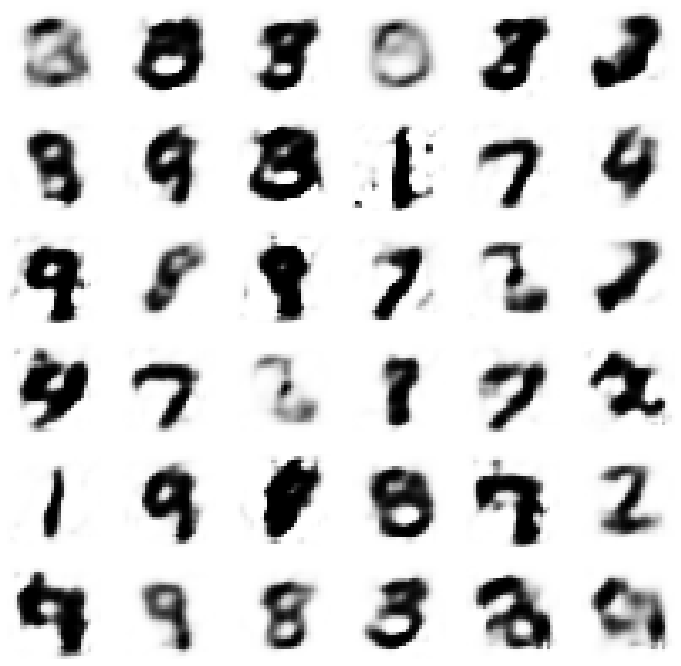

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.43it/s]


Elapsed time 38.4s
avg bce loss:  9454.842
avg kl loss:  351.4781
Epoch 21 [loss (avg) 10860.7554 | mu (sum): 0.05180925875902176 | logvar (sum): -2.74582576751709]


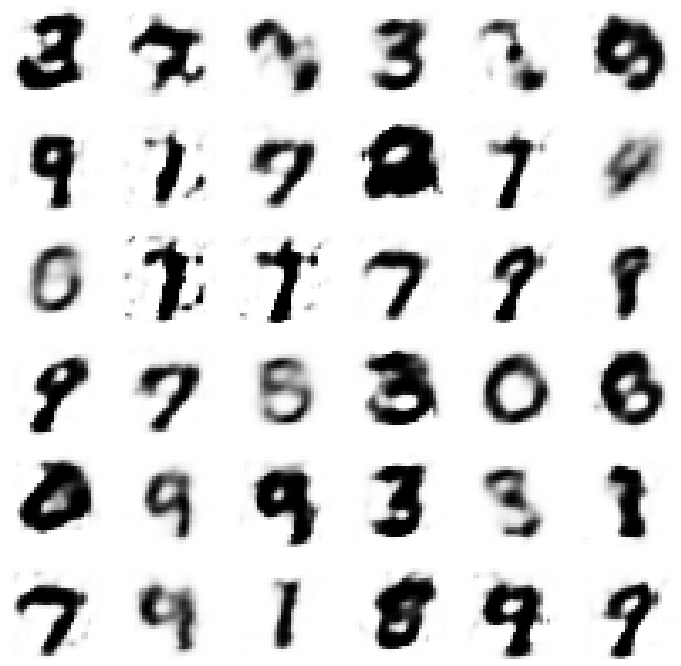

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.57it/s]


Elapsed time 39.8s
avg bce loss:  9434.416
avg kl loss:  351.21756
Epoch 22 [loss (avg) 10839.2860 | mu (sum): 0.048003118485212326 | logvar (sum): -2.7424583435058594]


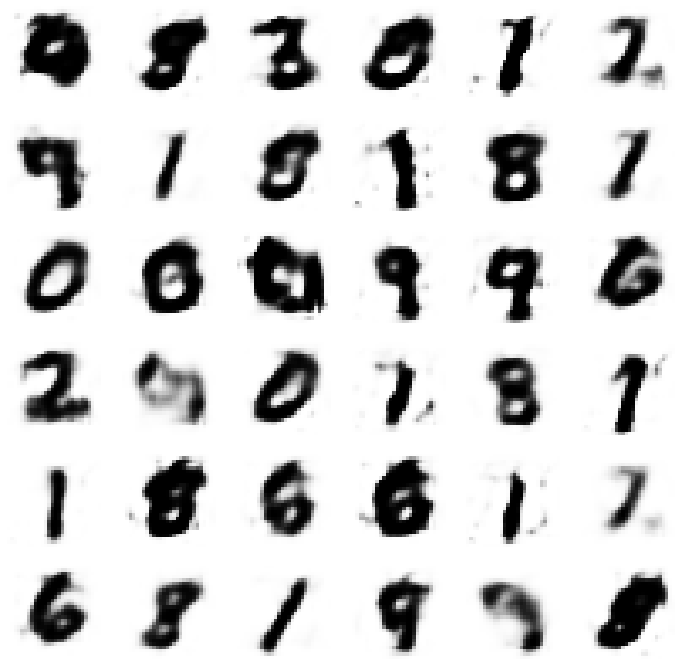

--------------------------------------------------


100%|██████████| 938/938 [00:38<00:00, 24.26it/s]


Elapsed time 38.7s
avg bce loss:  9416.876
avg kl loss:  350.3914
Epoch 23 [loss (avg) 10818.4417 | mu (sum): 0.04628705605864525 | logvar (sum): -2.7367594242095947]


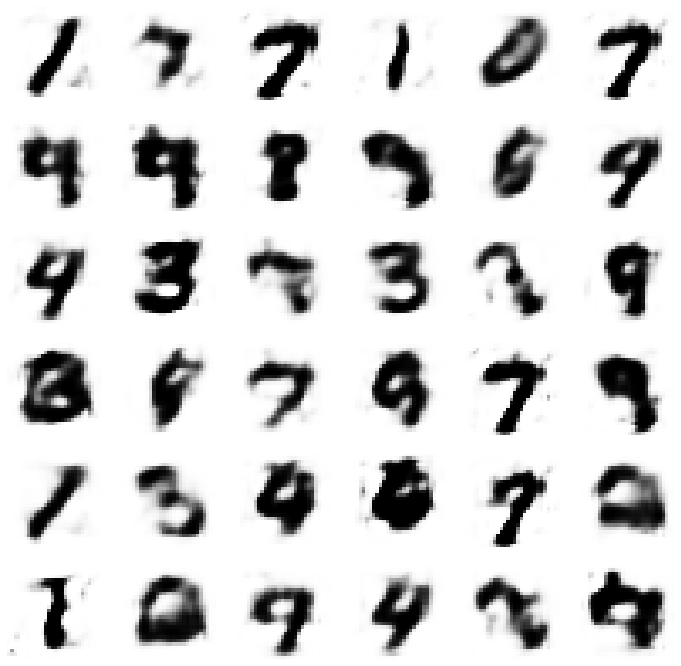

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 23.23it/s]


Elapsed time 40.4s
avg bce loss:  9407.048
avg kl loss:  351.1214
Epoch 24 [loss (avg) 10811.5336 | mu (sum): 0.045065321028232574 | logvar (sum): -2.7421507835388184]


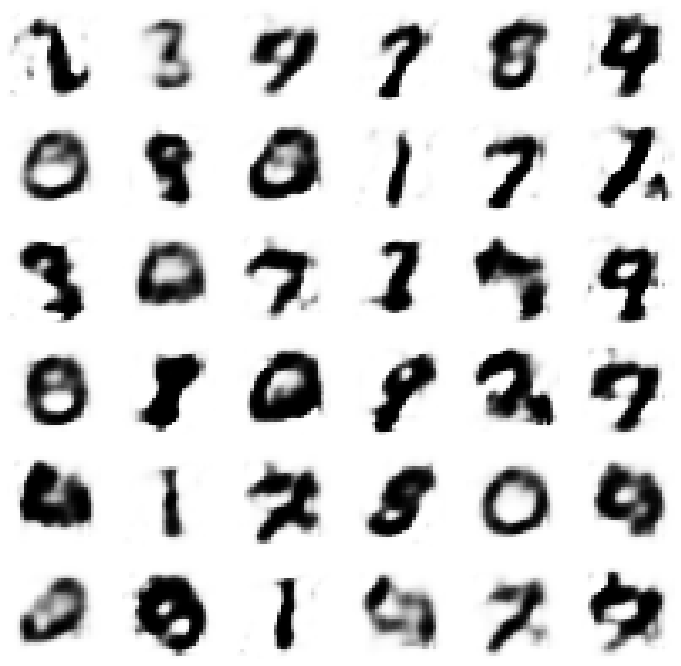

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.83it/s]


Elapsed time 39.4s
avg bce loss:  9393.968
avg kl loss:  352.41858
Epoch 25 [loss (avg) 10803.6421 | mu (sum): 0.045076943933963776 | logvar (sum): -2.7513530254364014]


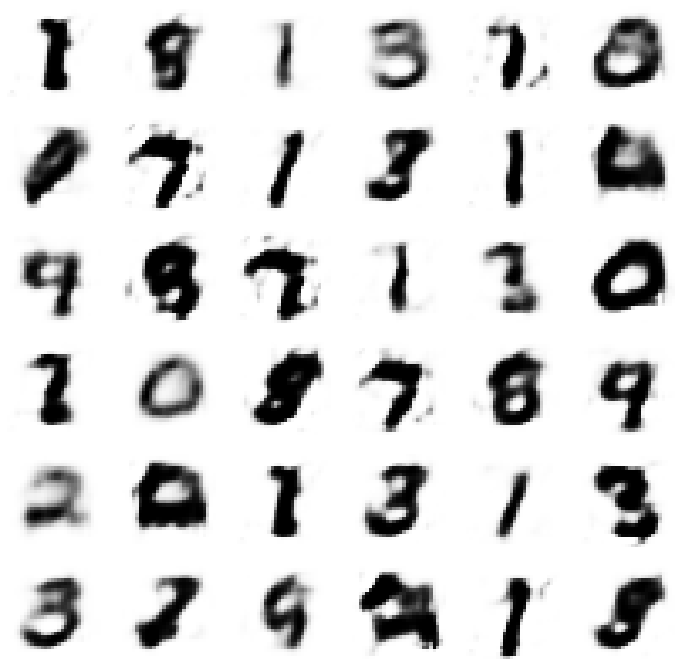

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.05it/s]


Elapsed time 42.6s
avg bce loss:  9387.902
avg kl loss:  351.91586
Epoch 26 [loss (avg) 10795.5661 | mu (sum): 0.04454011097550392 | logvar (sum): -2.7450950145721436]


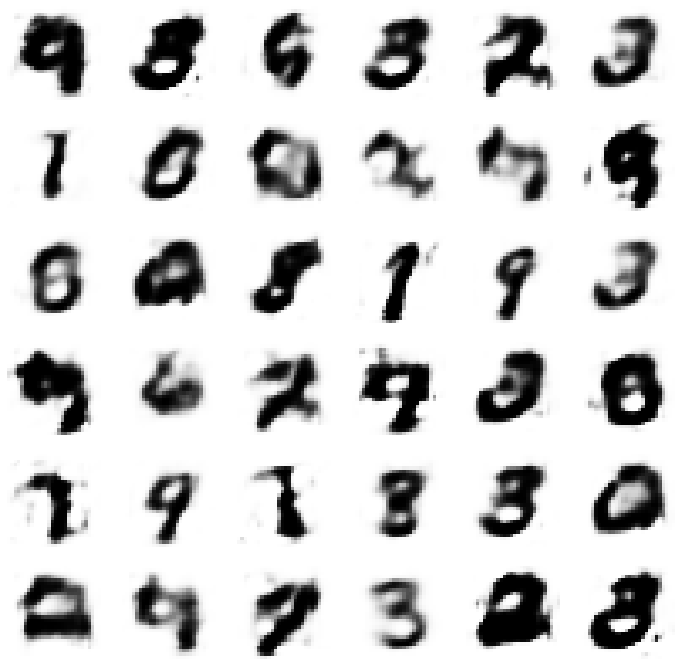

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.62it/s]


Elapsed time 39.7s
avg bce loss:  9377.2
avg kl loss:  351.6008
Epoch 27 [loss (avg) 10783.6026 | mu (sum): 0.04022586718201637 | logvar (sum): -2.7470884323120117]


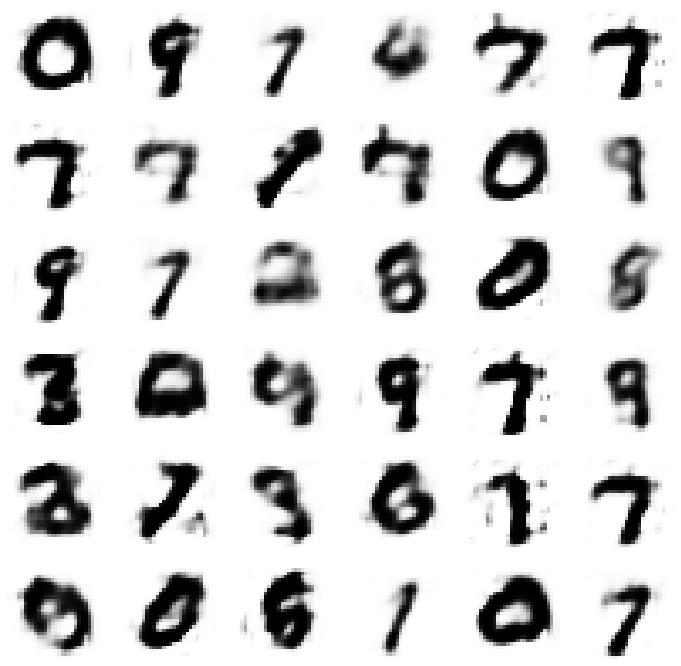

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 23.28it/s]


Elapsed time 40.3s
avg bce loss:  9368.139
avg kl loss:  351.59714
Epoch 28 [loss (avg) 10774.5275 | mu (sum): 0.03930758312344551 | logvar (sum): -2.7433807849884033]


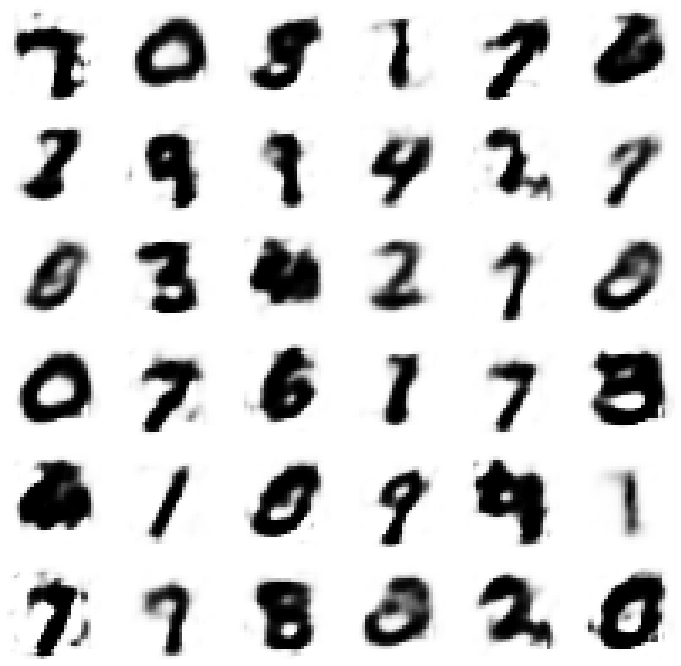

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.84it/s]


Elapsed time 41.1s
avg bce loss:  9363.602
avg kl loss:  351.76865
Epoch 29 [loss (avg) 10770.6760 | mu (sum): 0.04178353399038315 | logvar (sum): -2.745290517807007]


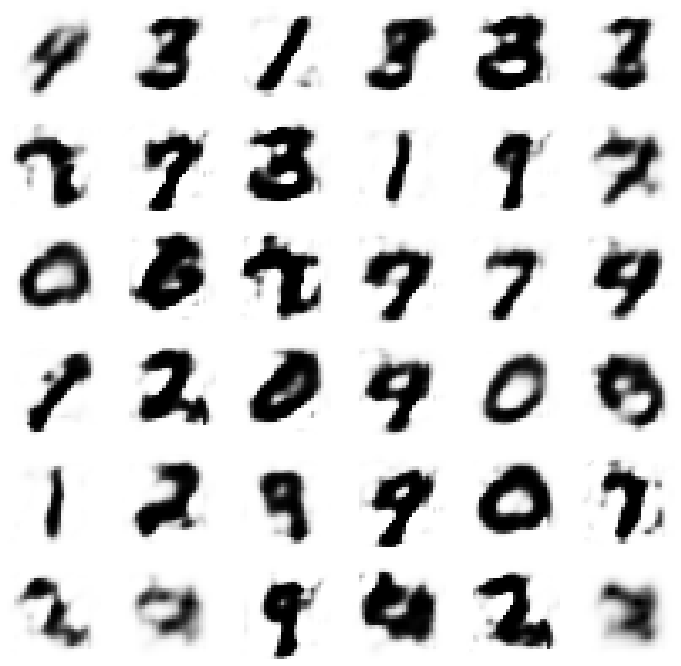

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.57it/s]


Elapsed time 39.8s
avg bce loss:  9363.507
avg kl loss:  351.65994
Epoch 30 [loss (avg) 10770.1461 | mu (sum): 0.03837301582098007 | logvar (sum): -2.7439141273498535]


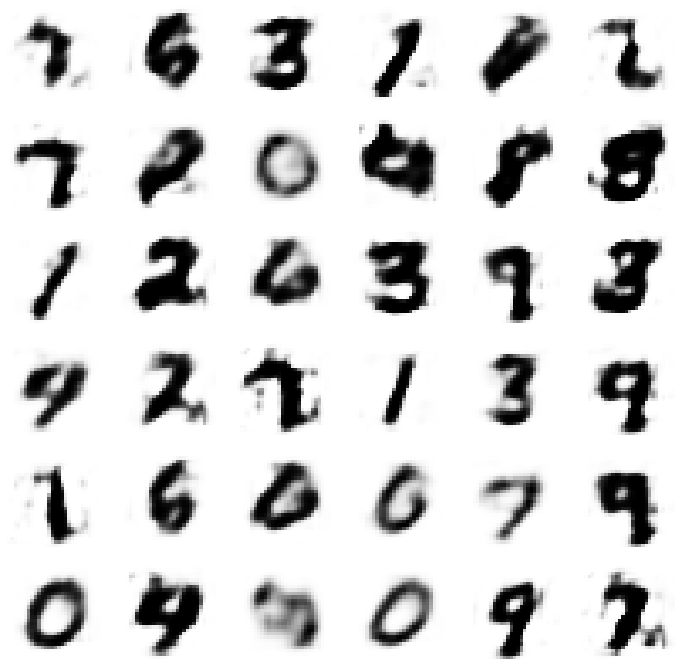

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 23.02it/s]


Elapsed time 40.8s
avg bce loss:  9350.26
avg kl loss:  353.21027
Epoch 31 [loss (avg) 10763.1021 | mu (sum): 0.03761518374085426 | logvar (sum): -2.759490728378296]


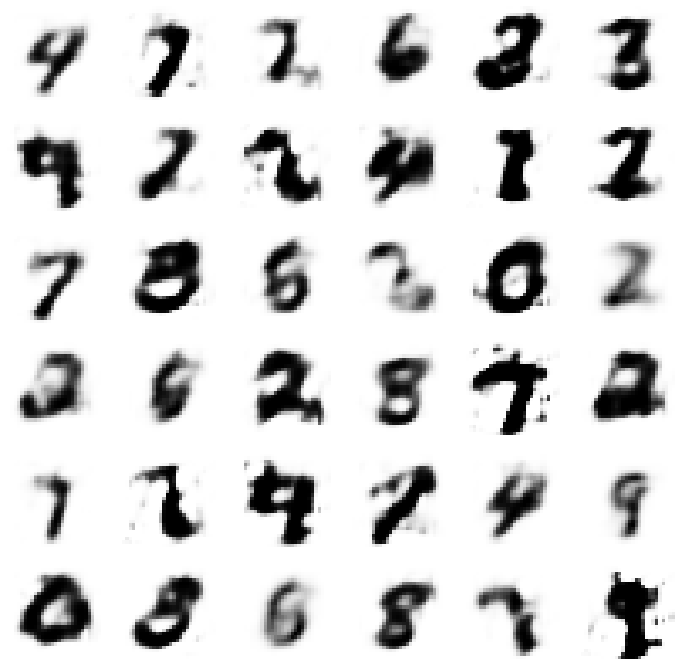

--------------------------------------------------


100%|██████████| 938/938 [00:39<00:00, 23.47it/s]


Elapsed time 40.0s
avg bce loss:  9348.798
avg kl loss:  352.2528
Epoch 32 [loss (avg) 10757.8085 | mu (sum): 0.03790266066789627 | logvar (sum): -2.749696969985962]


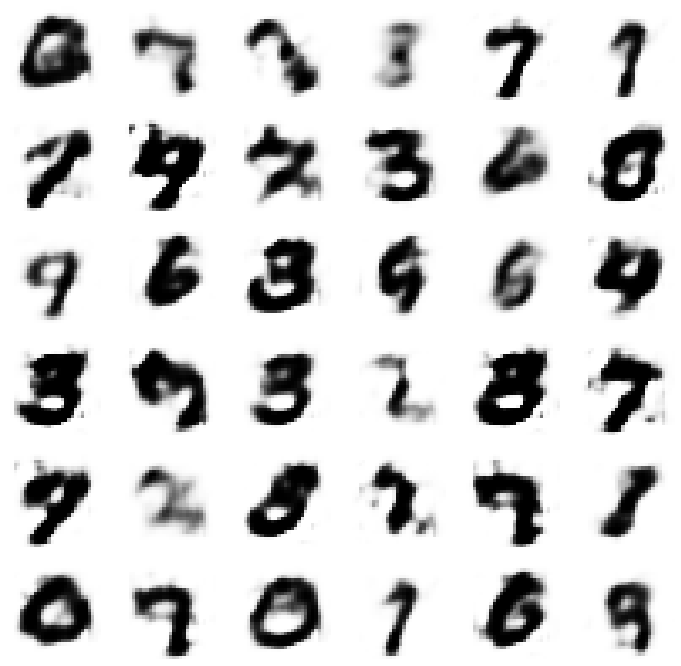

--------------------------------------------------


100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


Elapsed time 47.8s
avg bce loss:  9343.047
avg kl loss:  351.99426
Epoch 33 [loss (avg) 10751.0239 | mu (sum): 0.03609107807278633 | logvar (sum): -2.7468769550323486]


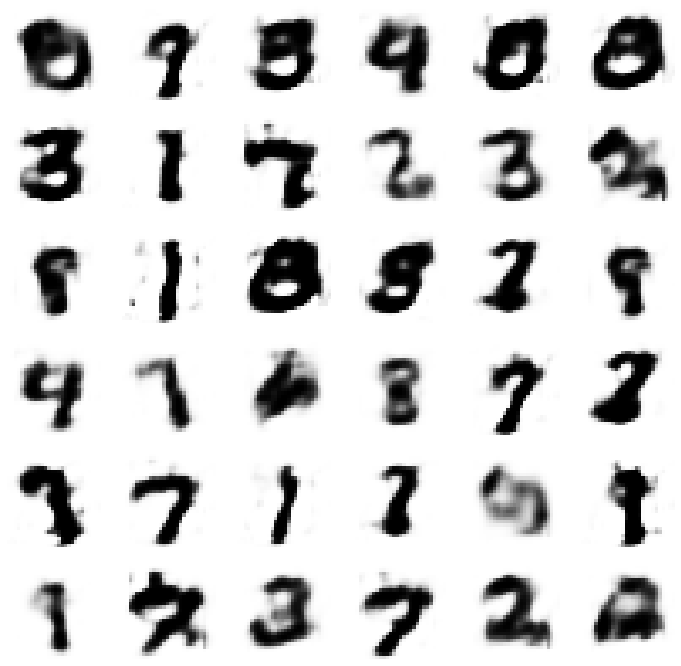

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.05it/s]


Elapsed time 42.6s
avg bce loss:  9336.305
avg kl loss:  351.5202
Epoch 34 [loss (avg) 10742.3852 | mu (sum): 0.033822037279605865 | logvar (sum): -2.7436835765838623]


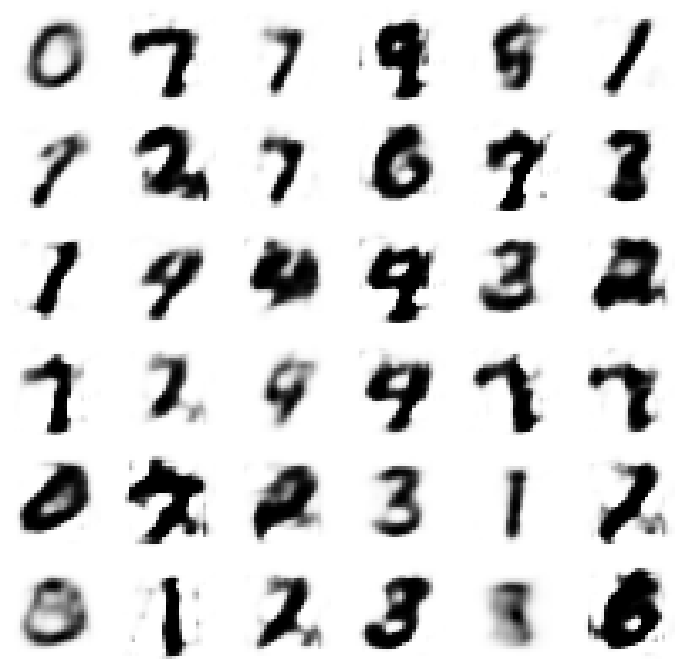

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.67it/s]


Elapsed time 41.4s
avg bce loss:  9333.533
avg kl loss:  352.5316
Epoch 35 [loss (avg) 10743.6602 | mu (sum): 0.03489318862557411 | logvar (sum): -2.7506370544433594]


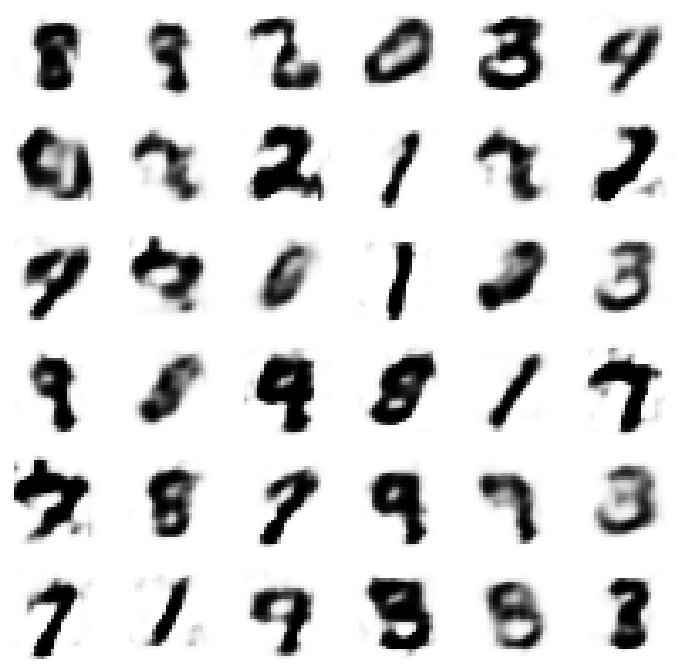

--------------------------------------------------


100%|██████████| 938/938 [00:45<00:00, 20.42it/s]


Elapsed time 45.9s
avg bce loss:  9328.003
avg kl loss:  351.74374
Epoch 36 [loss (avg) 10734.9782 | mu (sum): 0.03519401699304581 | logvar (sum): -2.7451703548431396]


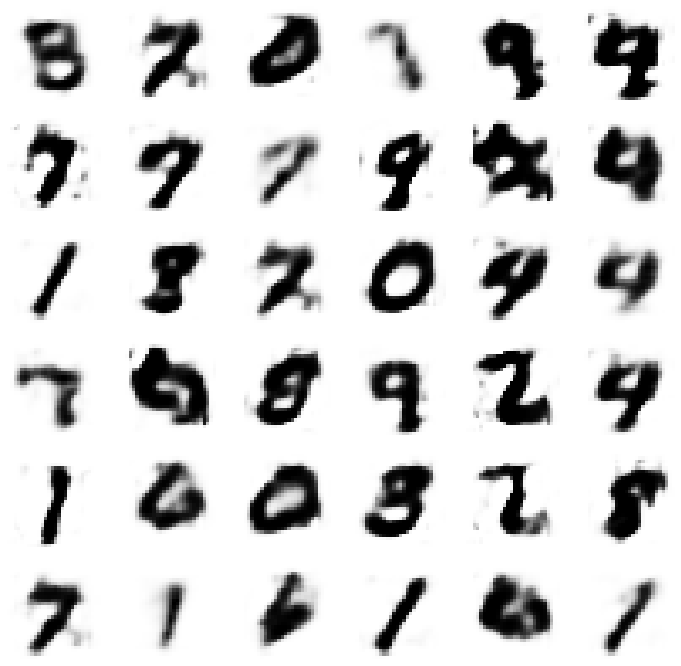

--------------------------------------------------


100%|██████████| 938/938 [00:43<00:00, 21.42it/s]


Elapsed time 43.8s
avg bce loss:  9322.618
avg kl loss:  352.3519
Epoch 37 [loss (avg) 10732.0262 | mu (sum): 0.034013863652944565 | logvar (sum): -2.750138282775879]


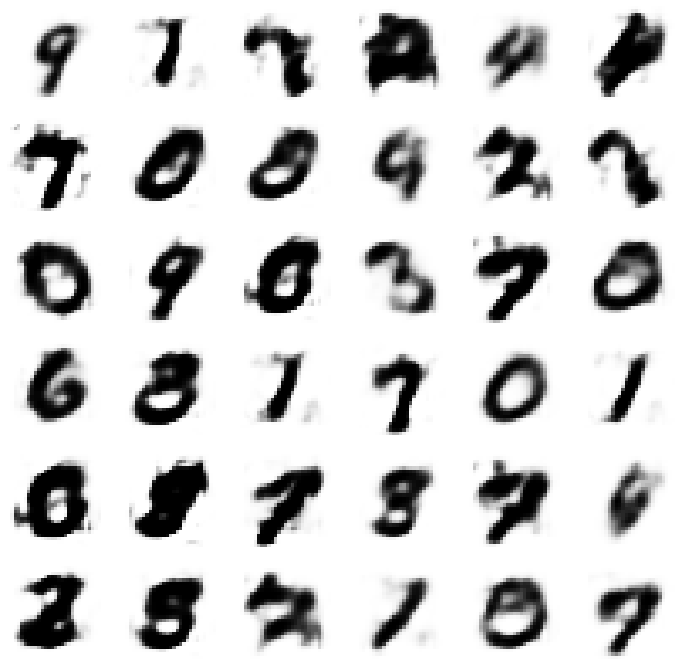

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.55it/s]


Elapsed time 41.6s
avg bce loss:  9317.97
avg kl loss:  352.225
Epoch 38 [loss (avg) 10726.8693 | mu (sum): 0.0342419296503067 | logvar (sum): -2.7523632049560547]


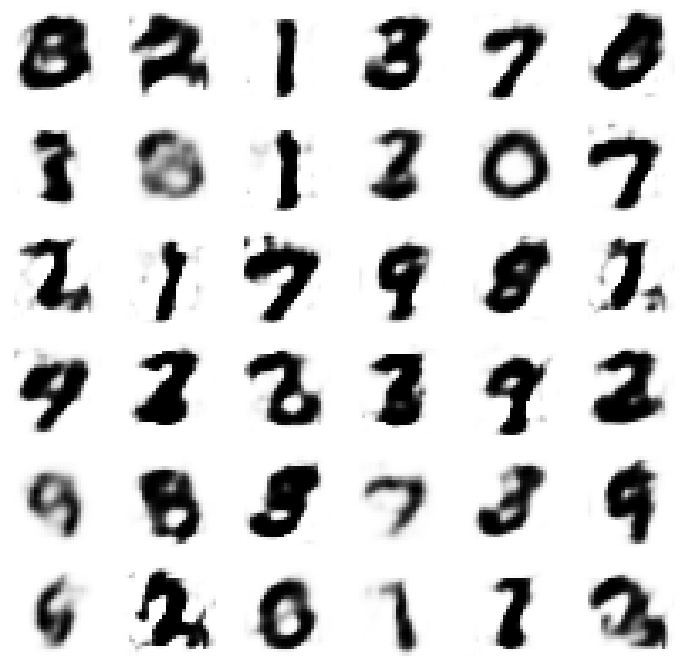

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.37it/s]


Elapsed time 42.0s
avg bce loss:  9313.422
avg kl loss:  351.81555
Epoch 39 [loss (avg) 10720.6843 | mu (sum): 0.03170764073729515 | logvar (sum): -2.746128559112549]


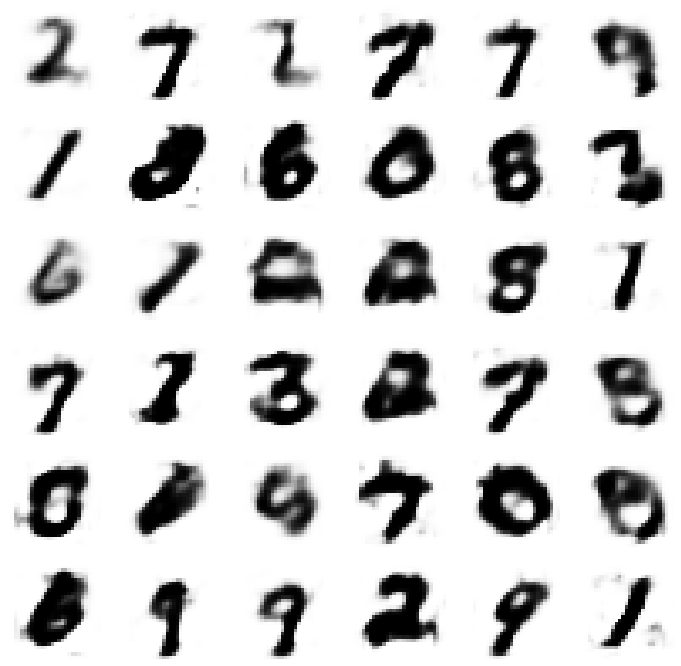

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.01it/s]


Elapsed time 42.6s
avg bce loss:  9305.202
avg kl loss:  351.98486
Epoch 40 [loss (avg) 10713.1431 | mu (sum): 0.02965514548122883 | logvar (sum): -2.7458808422088623]


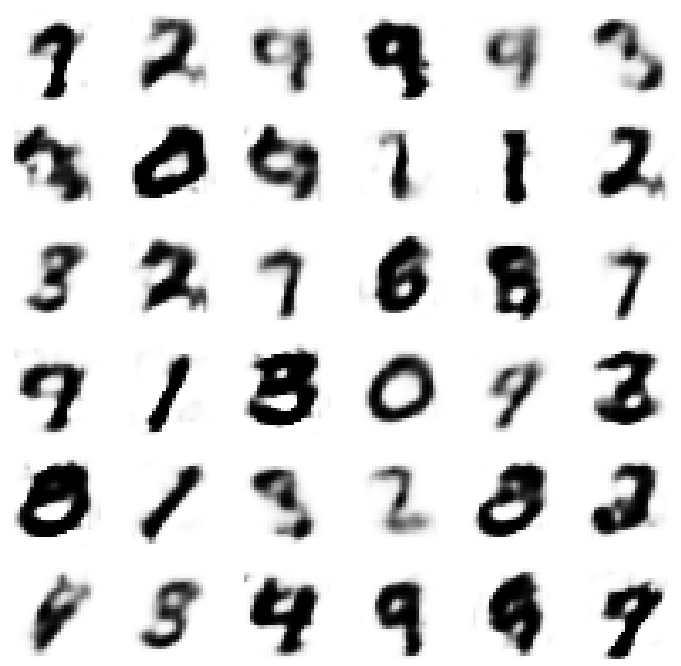

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.00it/s]


Elapsed time 42.6s
avg bce loss:  9299.137
avg kl loss:  351.0611
Epoch 41 [loss (avg) 10703.3816 | mu (sum): 0.0262693352997303 | logvar (sum): -2.741353988647461]


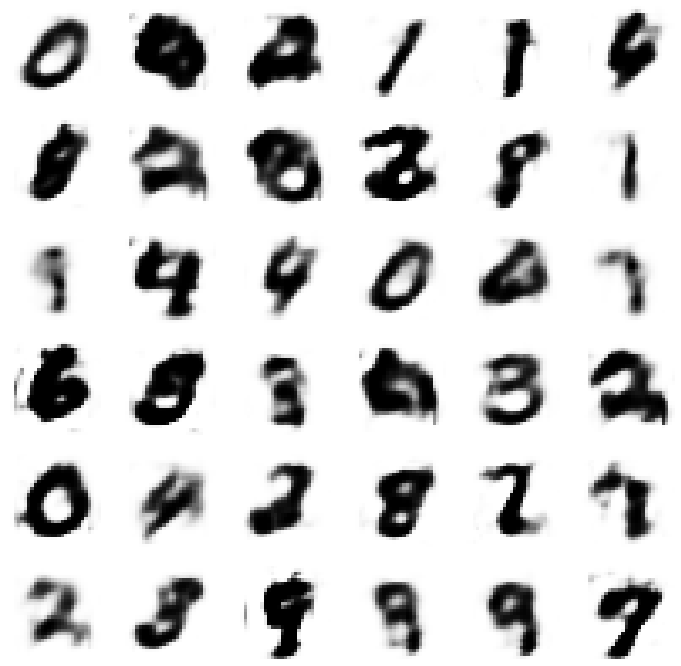

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.42it/s]


Elapsed time 41.9s
avg bce loss:  9294.923
avg kl loss:  351.44336
Epoch 42 [loss (avg) 10700.6965 | mu (sum): 0.02631489373743534 | logvar (sum): -2.744652032852173]


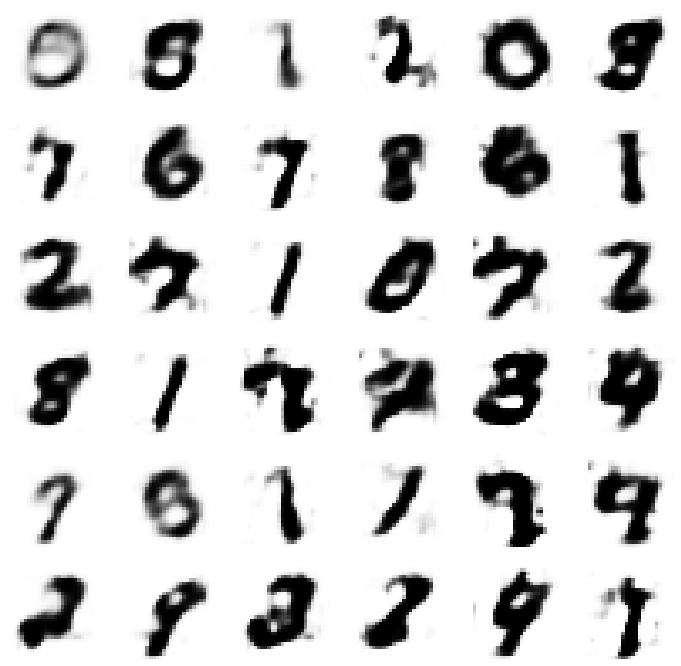

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.14it/s]


Elapsed time 42.4s
avg bce loss:  9290.228
avg kl loss:  352.155
Epoch 43 [loss (avg) 10698.8465 | mu (sum): 0.026494568213820457 | logvar (sum): -2.7503325939178467]


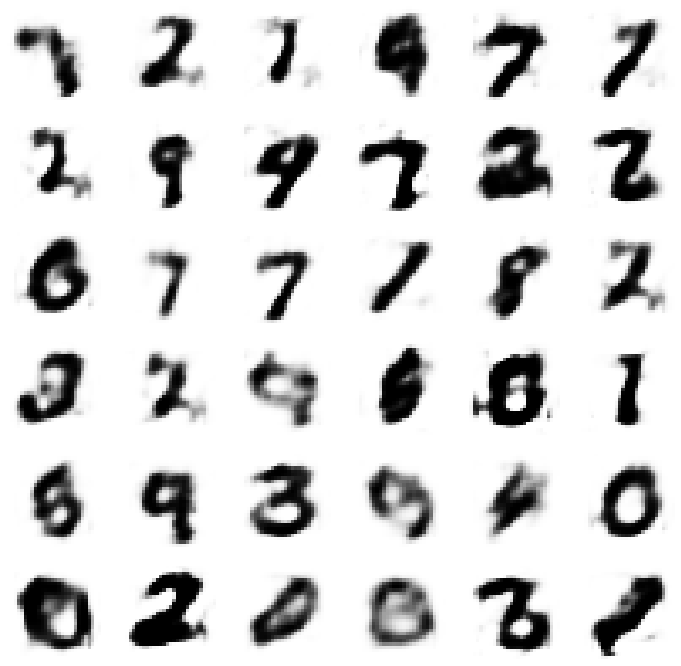

--------------------------------------------------


100%|██████████| 938/938 [00:40<00:00, 22.94it/s]


Elapsed time 40.9s
avg bce loss:  9287.328
avg kl loss:  351.45972
Epoch 44 [loss (avg) 10693.1662 | mu (sum): 0.026596128940582275 | logvar (sum): -2.7450153827667236]


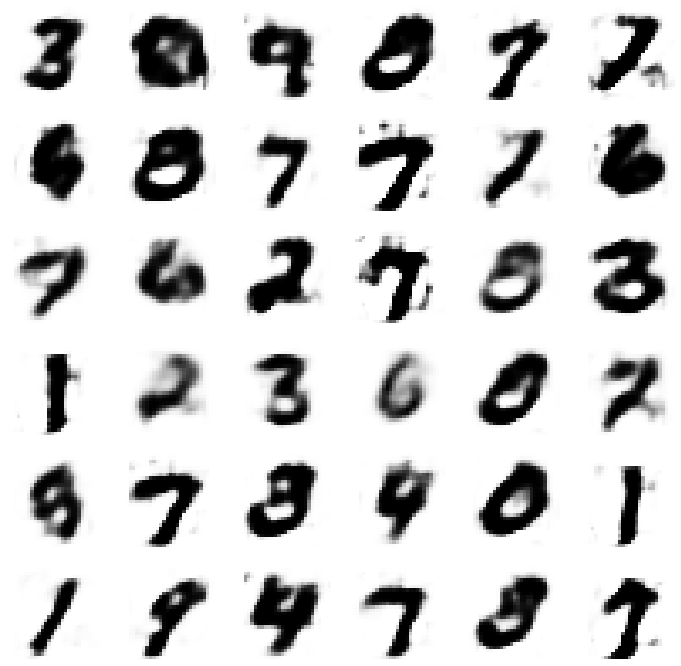

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 22.04it/s]


Elapsed time 42.6s
avg bce loss:  9283.512
avg kl loss:  351.73627
Epoch 45 [loss (avg) 10690.4562 | mu (sum): 0.024117568507790565 | logvar (sum): -2.7455124855041504]


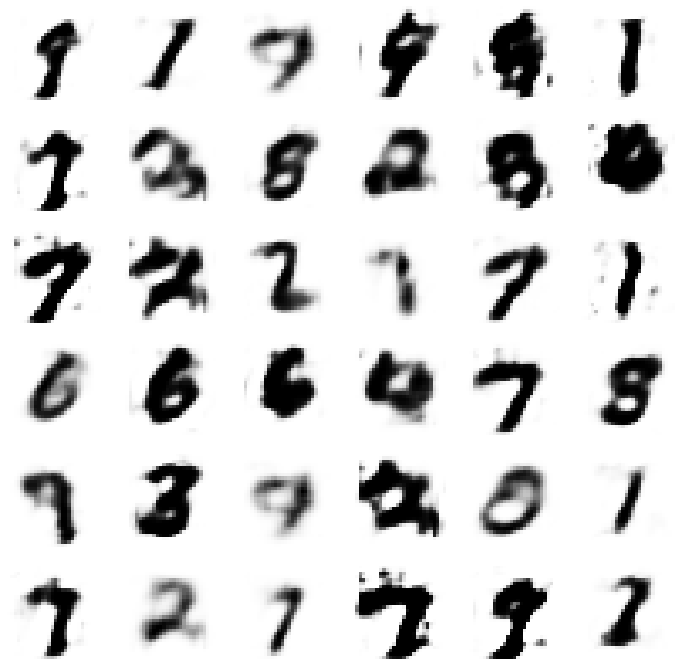

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.48it/s]


Elapsed time 41.7s
avg bce loss:  9277.149
avg kl loss:  351.28366
Epoch 46 [loss (avg) 10682.2836 | mu (sum): 0.021129252389073372 | logvar (sum): -2.742479085922241]


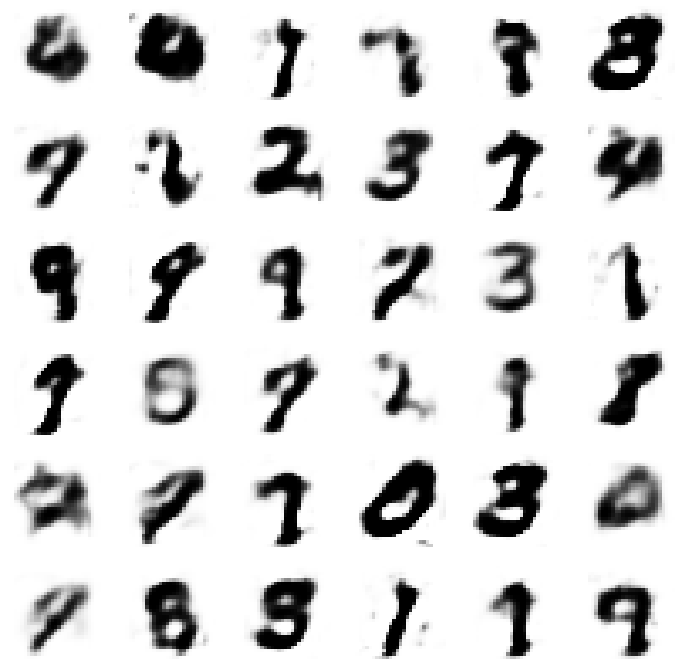

--------------------------------------------------


100%|██████████| 938/938 [00:42<00:00, 21.98it/s]


Elapsed time 42.7s
avg bce loss:  9273.666
avg kl loss:  351.77838
Epoch 47 [loss (avg) 10680.7797 | mu (sum): 0.019996533170342445 | logvar (sum): -2.745464324951172]


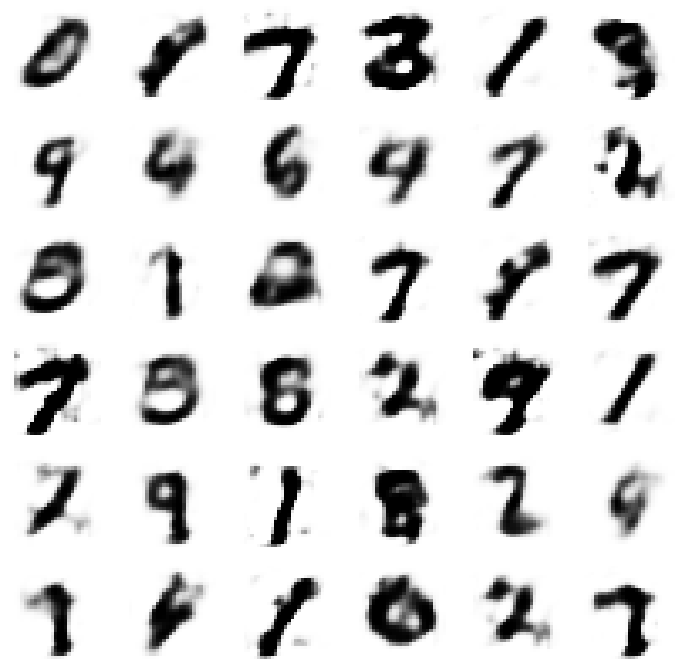

--------------------------------------------------


100%|██████████| 938/938 [00:41<00:00, 22.50it/s]


Elapsed time 41.7s
avg bce loss:  9269.944
avg kl loss:  351.65247
Epoch 48 [loss (avg) 10676.5551 | mu (sum): 0.018083706498146057 | logvar (sum): -2.744649648666382]


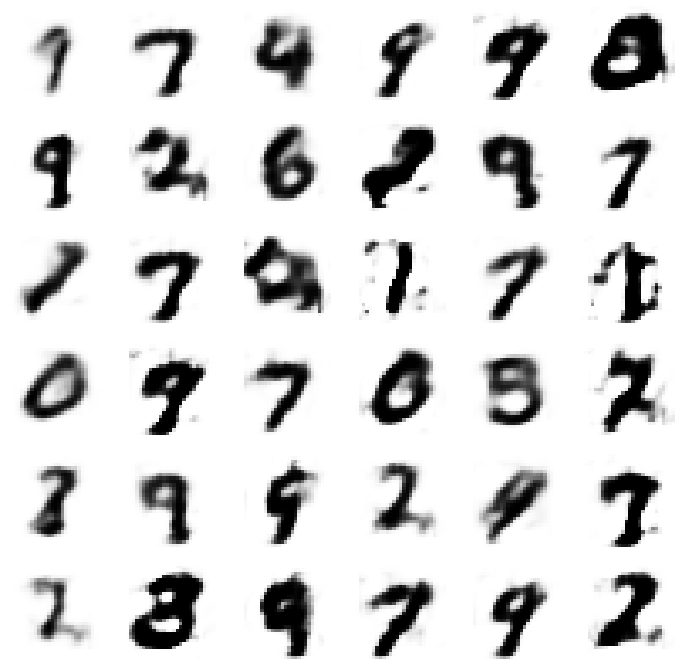

--------------------------------------------------


100%|██████████| 938/938 [00:43<00:00, 21.71it/s]


Elapsed time 43.2s
avg bce loss:  9263.567
avg kl loss:  351.61887
Epoch 49 [loss (avg) 10670.0425 | mu (sum): 0.017732523381710052 | logvar (sum): -2.74395489692688]


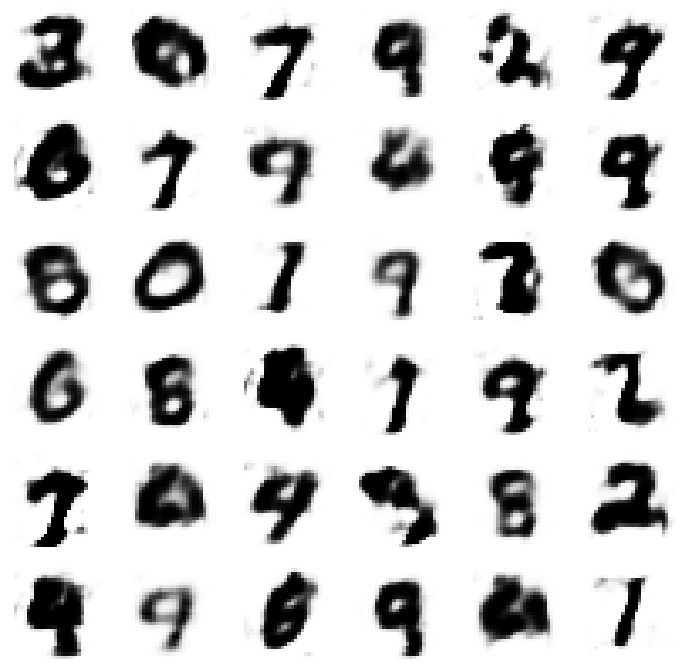

--------------------------------------------------


In [ ]:
config = dict(
    z_dim=4,
    seed=42, beta_0=2, beta_1=4, beta_1=8,
    batch_size=64, max_epoch=50,
    lr=3e-4, weight_decay=1e-5,
    num_workers=2, ds='MNIST'
)
seed_everything(config['seed'])
model = VAE(
    in_channels=1, hidden_dim=4, z_dim=config['z_dim'], linear_size=72
)
train(model, config)


In [ ]:
#@title Default title text
mu = 0 #@param {type:"number"}
log_var = -1 #@param {type:"number"}
z1 = 0.2 #@param {type:"number"}
z2 = -0.4 #@param {type:"number"}
z3 = 0.4 #@param {type:"number"}
z4 = -0.3 #@param {type:"number"}

mu = torch.tensor(mu)
log_var = torch.tensor(log_var)
z = torch.tensor([[z1, z2,  z3, z4]])
with torch.no_grad():
    dist = torch.distributions.normal.Normal(0, 1)
    if torch.cuda.is_available():
        dist.loc = dist.loc.cuda()
        dist.scale = dist.scale.cuda()
    #z = mu + log_var*dist.sample(torch.randn([1, config['z_dim']], device=device).shape)
    #z = mu + log_var * z
    y = model.forward_decoder(z)
    y = y[0]
    # y = mean + (y * std)
    plt.imshow(y.view(28, 28).cpu().numpy(), cmap='binary')
plt.axis('off')
plt.show()